EfficientNetB0 model to implement for the FeelBeat Project

In [1]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
model = ResNet50V2(weights='imagenet')
print(len(model.layers))

102869336/102869336 [==============================] - 6s 0us/step
192


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

In [3]:

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage.io
from keras.applications.nasnet import NASNetLarge
from skimage.transform import rescale, resize
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.optimizers import Adam

import pydot


In [4]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 96
FROZEN_LAYER_NUM = 300

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck+_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train_jaffe.zip' -d train







In [7]:

! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-private.zip' -d test



In [8]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-public.zip' -d dev


In [9]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug =='train':
        datagen = ImageDataGenerator(
                            rescale = 1./255,
                            validation_split =0.2,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode = 'nearest')
    else:
      datagen = ImageDataGenerator(rescale = 1./255)


    return datagen.flow_from_directory(
            dataset,
            target_size=(96, 96),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [10]:
train_generator = get_datagen('/content/train',True)
dev_generator = get_datagen('/content/dev')
test_generator =get_datagen('/content/test')

Found 30533 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [11]:
# Load the EfficientB) model
efficientnetb1_notop = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(Resize_pixelsize, Resize_pixelsize, 3))

# Get the output from the last layer
last_layer = efficientnetb1_notop.output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

# Add a new classifier layer
out = Dense(7, activation='softmax', name='classifier')(x)
# Create the model
model = Model(inputs=efficientnetb1_notop.input, outputs=out)


# List all the indices of layers that are batch normalization layers
batch_norm_indices = [
    i for i, layer in enumerate(efficientnetb1_notop.layers)
    if 'BatchNormalization' in layer.__class__.__name__
]
print(batch_norm_indices)

for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        efficientnetb1_notop.layers[i].trainable = False



initial_learning_rate_optim = ADAM_LEARNING_RATE

learning_rate_schedule_optim = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_optim,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optim = keras.optimizers.Adam(learning_rate=learning_rate_schedule_optim, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# early_stop_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     mode='min',
#     min_delta=0,
#     patience=20,
#     restore_best_weights=True,
#     verbose=2,
# )

rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=20, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop]


model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

82420632/82420632 [==============================] - 4s 0us/step
[3, 6, 10, 15, 18, 20, 23, 27, 30, 34, 37, 41, 44, 46, 49, 53, 56, 60, 63, 67, 70, 78, 80, 83, 91, 95, 98, 106, 110, 113, 121, 125, 128, 136, 140, 143, 151, 155, 158, 166, 168, 171, 179, 183, 186, 194, 198, 201, 209, 213, 216, 224, 228, 231, 239, 243, 246, 254, 258, 261, 269, 273, 276, 284, 288, 291, 299, 301, 304, 312, 316, 319, 327, 331, 334, 342, 346, 349, 357, 361, 364, 372, 376, 379, 387, 391, 394, 402, 406, 409, 417, 421, 424, 432, 436, 439, 447, 451, 454, 462, 466, 469, 477, 481, 484, 492, 496, 499, 507, 511]


In [12]:
history = model.fit(
    x=train_generator,
    validation_data=test_generator,
    shuffle=True,
    steps_per_epoch = 28709//BS,
    validation_steps = 3509//BS,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=True
)

Epoch 1/50
224/224 [==============================] - 145s 369ms/step - loss: 1.7013 - accuracy: 0.3805 - val_loss: 1.3554 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 2/50
224/224 [==============================] - 81s 360ms/step - loss: 1.3799 - accuracy: 0.4837 - val_loss: 1.3029 - val_accuracy: 0.5017 - lr: 0.0010
Epoch 3/50
224/224 [==============================] - 82s 363ms/step - loss: 1.2316 - accuracy: 0.5438 - val_loss: 1.2255 - val_accuracy: 0.5272 - lr: 0.0010
Epoch 4/50
224/224 [==============================] - 81s 363ms/step - loss: 1.1221 - accuracy: 0.5900 - val_loss: 1.1708 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 5/50
224/224 [==============================] - 82s 363ms/step - loss: 1.0026 - accuracy: 0.6375 - val_loss: 1.1665 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 6/50
224/224 [==============================] - 82s 365ms/step - loss: 0.8930 - accuracy: 0.6827 - val_loss: 1.1643 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 7/50
224/224 [==============================]

In [14]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('Test loss, Test acc: ',results_test)



# Evaluate on test data


<ipython-input-14-370b98cc6c28>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_generator, 3509 // BS)


Test loss, Test acc:  [2.0275075435638428, 0.6192129850387573]


In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data


<ipython-input-15-5b76f0701e1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(dev_generator, 3509 // BS)


dev loss, dev acc: [2.3643665313720703, 0.6114004850387573]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


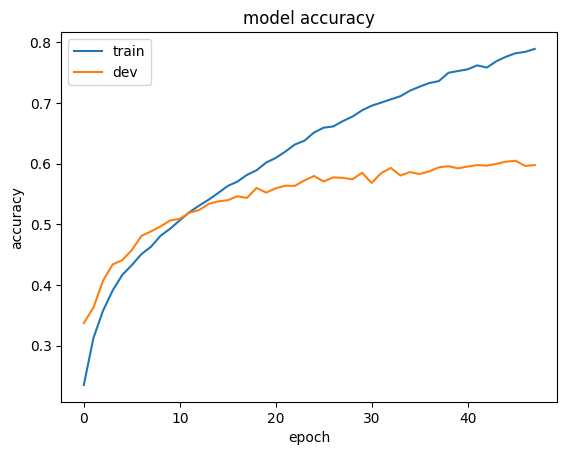

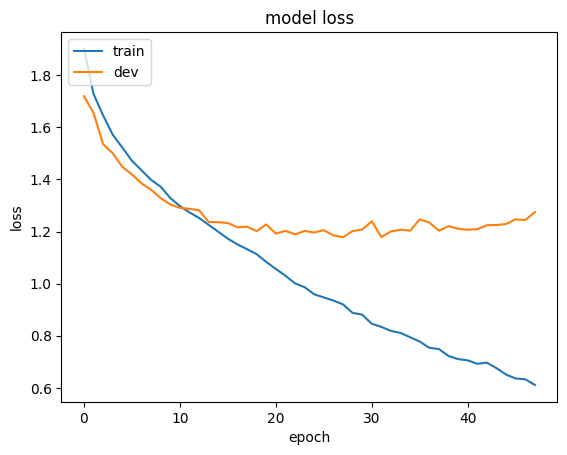

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/CSE499A/models' + 'EfficientNetV2S' + epoch_str + test_acc + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,600000)